In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import itertools
import tqdm
from collections import Counter
from IPython.display import display, Markdown
from matplotlib import pyplot as plt

In [2]:
START_NODE = 'START' 

def sample_beta_pert(o, m, p, lamb=4, size=None):
    alpha = 1 + lamb * (m - o) / (p - o)
    beta = 1 + lamb * (p - m) / (p - o)
    beta_samples = np.random.beta(alpha, beta, size=size)
    return o + beta_samples * (p - o)    

def add_features(df:pd.DataFrame)->pd.DataFrame:
    # TE - estimated time
    # TE_Var - variation of TE
    # TE_StDev - standard deviation of TE
    df['TE'] = np.round((df['O'] + 4 *df['M'] + df['P'])/6,2)
    df['TE_Var'] = np.round(((df['P'] - df['O'])/6)**2,2)
    df['TE_StDev'] = np.round(df['TE_Var']**0.5,2)

    return df

def get_project_features(df:pd.DataFrame)->dict:
    TE_proj = np.round(df['TE'].sum(),2)
    Var_proj = np.round(df['TE_Var'].sum(),2)
    StDev_proj = np.round(Var_proj**0.5,2)
    return {'TE_proj':TE_proj,'TE_Var_proj':Var_proj, 'TE_StDev_proj':StDev_proj}

def sample_duration(df:pd.DataFrame)->pd.DataFrame:
    df['duration_beta_pert'] = sample_beta_pert(o=df['O'],m=df['M'],p=df['P'])
    return df    

def create_project_graph(df:pd.DataFrame)->nx.DiGraph:

    graph = nx.DiGraph()
    
    labeldict = {}
    for ix, row in df.iterrows():
        labeldict[row['TaskId']]=row['TaskName']
    
    _ = df.apply(lambda x: graph.add_node(x['TaskId'], id=x['TaskId'], name=x['TaskName']),axis=1)

    for ix, row in df[~df['PrevTaskId'].isna()].iterrows():
        if ',' in str(row['PrevTaskId']):
            prev_ids = [int(i) for i in str(row['PrevTaskId']).split(',')]
            for prev_id in prev_ids:
                source_id = prev_id
                target_id = row['TaskId']
                te = df[df['TaskId']==target_id]['TE'].values[0]

                duration_beta_pert = df[df['TaskId']==target_id]['duration_beta_pert'].values[0]
                graph.add_edge(u_of_edge=source_id, v_of_edge=target_id, duration_TE=te, duration_beta_pert=duration_beta_pert)
        else:
            source_id = int(row['PrevTaskId'])
            target_id = row['TaskId']
            te = df[df['TaskId']==target_id]['TE'].values[0]
            duration_beta_pert = df[df['TaskId']==target_id]['duration_beta_pert'].values[0]
            graph.add_edge(u_of_edge=source_id, v_of_edge=target_id, duration_TE=te, duration_beta_pert=duration_beta_pert)

    te = df[df['TaskId']==1]['TE'].values[0]
    duration_beta_pert = df[df['TaskId']==1]['duration_beta_pert'].values[0]

    graph.add_node(START_NODE, name=START_NODE)
    graph.add_edge(START_NODE,1, duration_TE=te, duration_beta_pert=duration_beta_pert)
    return graph

def calculate_critical_path(graph, weight='weight')->dict:
    cpm_path = nx.dag_longest_path(G=graph, weight=weight)
    cpm_duration = nx.dag_longest_path_length(G=graph, weight=weight)
    return {'path':cpm_path, 'duration':cpm_duration}

def draw_critical_path(graph:nx.DiGraph, cpm_path:list, color:str='red')->nx.DiGraph:

    node_color_map = []
    for node in graph:
        if node=='START':
            node_color_map.append('grey')
        elif node in cpm_path:
            node_color_map.append(color)
        else: 
            node_color_map.append('lightblue')
            
    cpm_edges = [(cpm_path[i], cpm_path[i+1]) for i in range(0,len(cpm_path)-1)]
    edge_color_map = []       
    for edge in graph.edges:
        if edge in cpm_edges:
            edge_color_map.append(color)
        else:
            edge_color_map.append('lightblue')
    nx.draw_networkx(graph,pos=nx.drawing.layout.bfs_layout(graph, start='START'), node_color=node_color_map, edge_color=edge_color_map, with_labels=True)
    return graph    

def monte_carlo_simulation(df, n_iter=10000, weight:str=None):
    results = []
    for _ in tqdm.tqdm(range(n_iter), desc="Monte Carlo simulation"):
        df = sample_duration(df=df)
        G = create_project_graph(df=df)
        cpm = calculate_critical_path(G, weight=weight)
        results.append(cpm)
    return results

def get_most_common_critical_path(mc_result:dict):
    duration_paths = [tuple(r['path']) for r in mc_result]        
    path_counter = Counter(tuple(duration_paths))
    duration_path = path_counter.most_common(1)[0][0]
    return duration_path
    

> **Estymacja PERT projektu**

,Wartość
Szacowany czas (TE):,190.18
Odchylenie standardowe:,9.71


,TaskId,TaskName,PrevTaskId,O,M,P,TE,TE_Var,TE_StDev
0,1,Instalacja i konfiguracja kamer na linii produ...,NaN,2,3,5,3.17,0.25,0.50
1,2,Zbieranie i anotacja danych wideo i obrazów z ...,1,5,8,15,8.67,2.78,1.67
2,3,Eksploracyjna analiza i przygotowanie danych,2,10,20,25,19.17,6.25,2.50
3,4,Budowa prototypu do testowania w warunkach lab...,1,1,2,5,2.33,0.44,0.66
4,5,Stworzenie symulacji komputerowej linii produk...,1,5,15,20,14.17,6.25,2.50
5,6,Wybór architektury modeli AI do detekcji anomalii,3,3,5,8,5.17,0.69,0.83
6,7,Trenowanie modeli AI do detekcji anomalii,6,15,30,40,29.17,17.36,4.17
7,8,Walidacja i testowanie modeli na danych testowych,7,5,8,10,7.83,0.69,0.83
8,9,Testowanie modeli na prototypie laboratoryjnym,"4,8",2,6,8,5.67,1.00,1.00
9,10,Testowanie modeli w środowisku symulacyjnym,"5,8",3,7,10,6.83,1.36,1.17


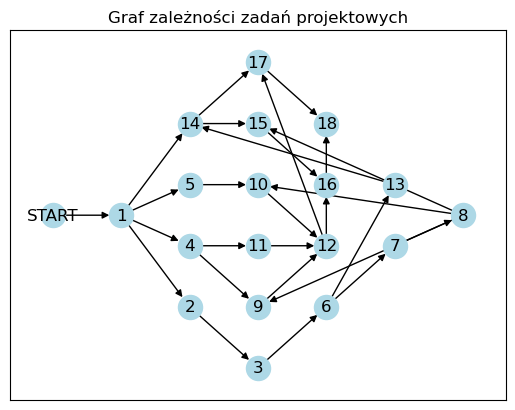

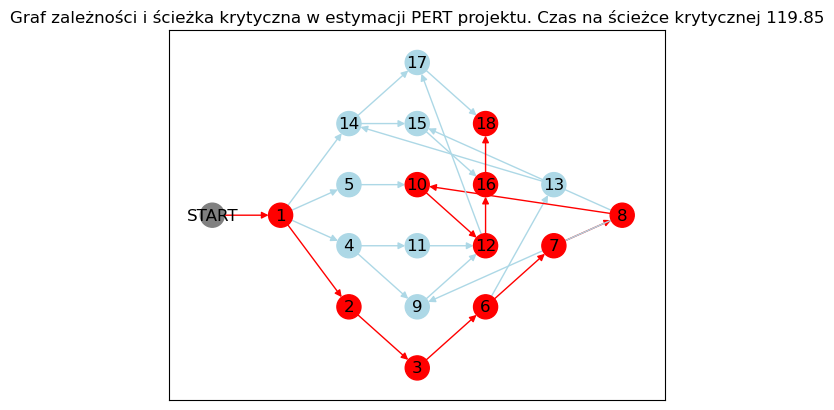

Monte Carlo simulation: 100%|████████████████████████████████████████████████████| 10000/10000 [02:46<00:00, 60.19it/s]


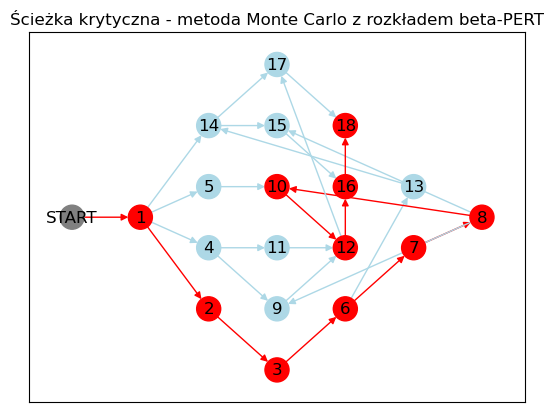

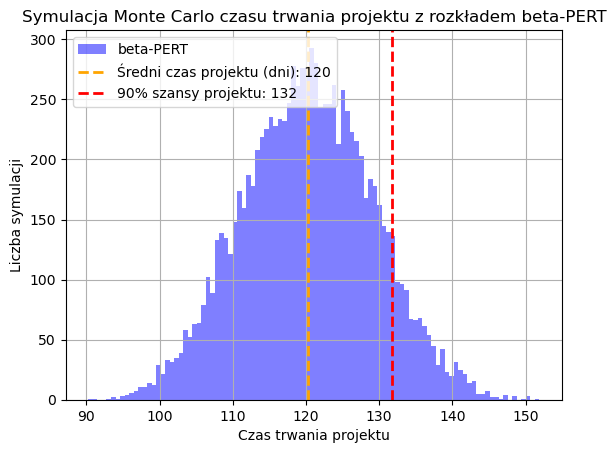

> **Prawdopodobieństewo sukcesu w zależności od zakładanego czasu trwania projektu**

,P %,Czas (dni)
0,50,120
1,60,122
2,70,125
3,80,127
4,90,131
5,95,135


> **Prawdopodobieństewo wystąpienia ściezki jako krytycznej**

,Ścieżka,% wystepowania
0,"(START, 1, 2, 3, 6, 7, 8, 10, 12, 16, 18)",67.62
1,"(START, 1, 2, 3, 6, 7, 8, 9, 12, 16, 18)",22.24
2,"(START, 1, 2, 3, 6, 7, 8, 15, 16, 18)",10.14


> **Częstość wystepowania ścieżek krytycznych**

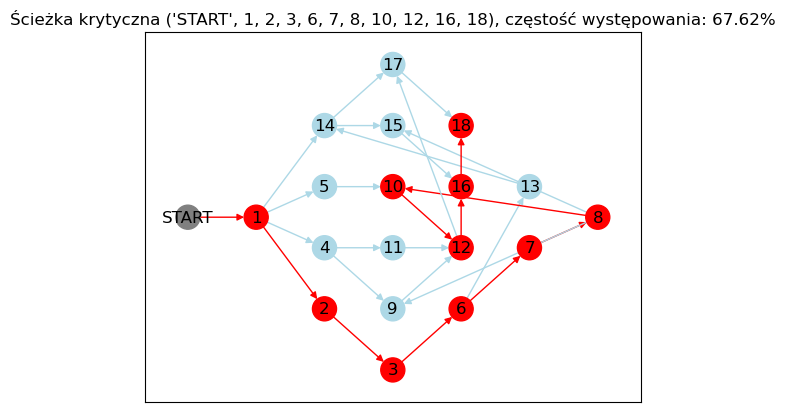

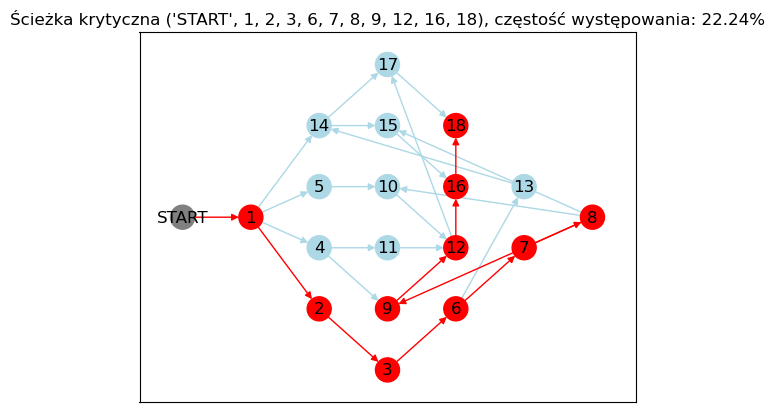

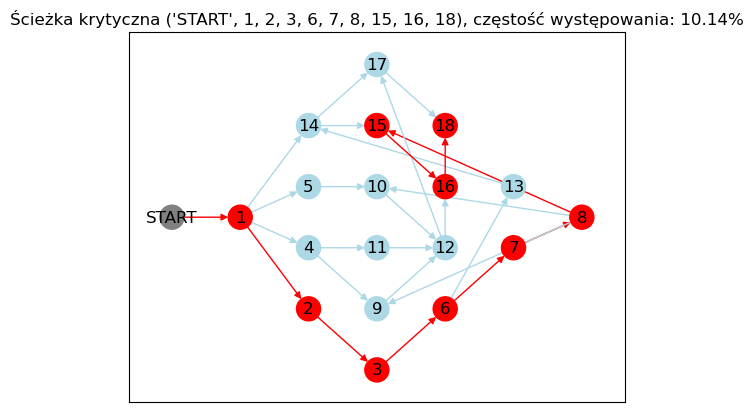

> **Zadania na ścieżce krytycznej**

,TaskId,% na ścieżce krytycznej
0,1,100.00
1,2,100.00
2,3,100.00
3,6,100.00
4,7,100.00
5,8,100.00
8,16,100.00
9,18,100.00
7,12,89.86
6,10,67.62


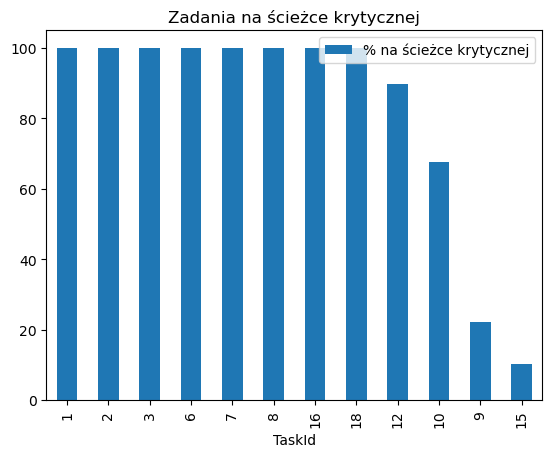

In [3]:
#Ustawienie generatora liczb losowych
np.random.seed(42)

#liczba symulacji Monte Carlo, minimum > 1000
MC_STEPS = 10000

#Odczyt przykładowych danych 
df_pert = pd.read_csv('./pert_sample1.csv', sep=';')

df_pert = add_features(df=df_pert)
project_features = get_project_features(df=df_pert)

display(Markdown('> **Estymacja PERT projektu**'))
pert_proj = {
    'Szacowany czas (TE):':project_features['TE_proj'],
    'Odchylenie standardowe:':project_features['TE_StDev_proj']
}
display(pd.DataFrame.from_dict(pert_proj, orient='index',columns=['Wartość']))


#Wyświetlenie danych w Jupyter
display(df_pert[['TaskId','TaskName','PrevTaskId','O','M','P','TE','TE_Var','TE_StDev']])

#Graf zależności zadań projektowych
df_pert = sample_duration(df=df_pert)
graph = create_project_graph(df=df_pert)
nx.draw_networkx(graph,pos=nx.drawing.layout.bfs_layout(graph, start=START_NODE), node_color='lightblue')
plt.title('Graf zależności zadań projektowych')
plt.show()


#Ścieżka krytyczna w estymacji PERT
cpm = calculate_critical_path(graph=graph, weight='duration_TE')
_ = draw_critical_path(graph=graph,cpm_path=cpm['path'], color='red')
plt.title(f"Graf zależności i ścieżka krytyczna w estymacji PERT projektu. Czas na ścieżce krytycznej {cpm['duration']}")
plt.show()

#Symulacja Monte Carlo estymacji projektu
mc_results = monte_carlo_simulation(df=df_pert, n_iter=MC_STEPS, weight='duration_beta_pert')
critical_path = get_most_common_critical_path(mc_results)
_ = draw_critical_path(graph=graph,cpm_path=critical_path, color='red')
plt.title("Ścieżka krytyczna - metoda Monte Carlo z rozkładem beta-PERT")
plt.show()

#Wykres symulacji czasu trwania projetku
duration = [r['duration'] for r in mc_results]
duration_mean = np.mean(duration)
duration_percentile_90_beta = np.percentile(duration, 90)

plt.hist(duration, bins=100, alpha=0.5, label='beta-PERT', color='blue')
plt.axvline(duration_mean, color='orange', linestyle='dashed', linewidth=2, label=f'Średni czas projektu (dni): {duration_mean:.0f}')
plt.axvline(duration_percentile_90_beta, color='red', linestyle='dashed', linewidth=2, label=f'90% szansy projektu: {duration_percentile_90_beta:.0f}')
plt.title("Symulacja Monte Carlo czasu trwania projektu z rozkładem beta-PERT")
plt.xlabel("Czas trwania projektu")
plt.ylabel("Liczba symulacji")
plt.legend()
plt.grid(True)
plt.show()

#Prawdopodobieństwo ile potrzeba dni na ukończenie projektu
percentiles = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

duration_for_percentile = {
    "P %": [int(p * 100) for p in percentiles],
    "Czas (dni)": [int(np.percentile(duration, p * 100)) for p in percentiles]
}

df_percentiles = pd.DataFrame(duration_for_percentile)
display(Markdown('> **Prawdopodobieństewo sukcesu w zależności od zakładanego czasu trwania projektu**'))
display(df_percentiles)

crital_paths = {
    'Ścieżka': [c[0] for c in Counter([tuple(r['path']) for r in mc_results]).most_common()],
    '% wystepowania': [c[1]/MC_STEPS*100 for c in Counter([tuple(r['path']) for r in mc_results]).most_common()]
}

df_crital_paths = pd.DataFrame(crital_paths)
display(Markdown('> **Prawdopodobieństewo wystąpienia ściezki jako krytycznej**'))
display(df_crital_paths)

display(Markdown('> **Częstość wystepowania ścieżek krytycznych**'))
for c in Counter([tuple(r['path']) for r in mc_results]).most_common():
    _ = draw_critical_path(graph=graph,cpm_path=c[0], color='red')
    plt.title(f'Ścieżka krytyczna {c[0]}, częstość występowania: {c[1]/MC_STEPS*100}%')
    plt.show()

critical_tasks = {}
for c in Counter([tuple(r['path']) for r in mc_results]).most_common():
    for t in c[0]:
        if t != 'START':
            if t in critical_tasks:
                critical_tasks[t] = critical_tasks[t] + c[1]
            else:
                critical_tasks[t] = c[1]
df_critical_tasks = pd.DataFrame.from_dict(critical_tasks, orient='index').reset_index()
df_critical_tasks[0] = df_critical_tasks[0]/100 
df_critical_tasks = df_critical_tasks.rename(columns={'index':'TaskId', 0:'% na ścieżce krytycznej'})
df_critical_tasks = df_critical_tasks.sort_values('% na ścieżce krytycznej', ascending=False)

display(Markdown('> **Zadania na ścieżce krytycznej**'))
display(df_critical_tasks)
df_critical_tasks.plot.bar(x='TaskId',y='% na ścieżce krytycznej')
plt.title('Zadania na ścieżce krytycznej')
plt.show()

> **Częstość wystepowania ścieżek krytycznych**

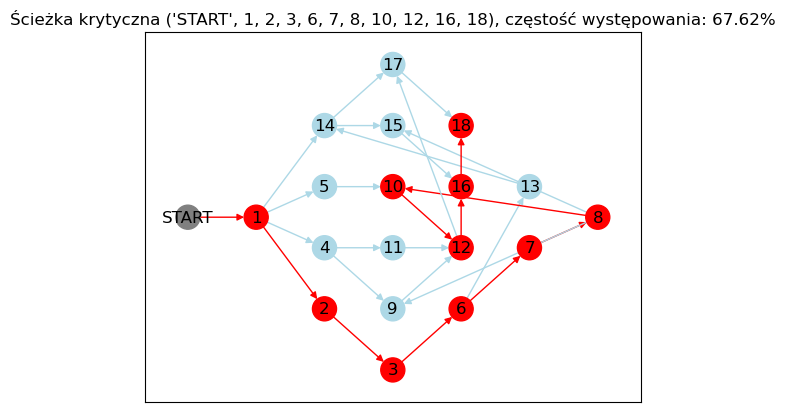

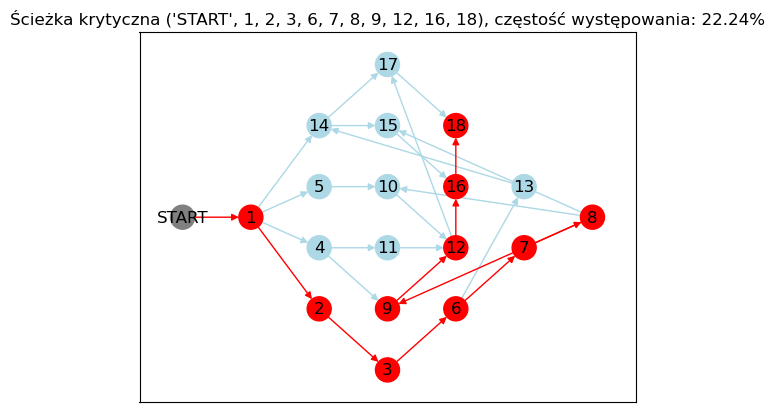

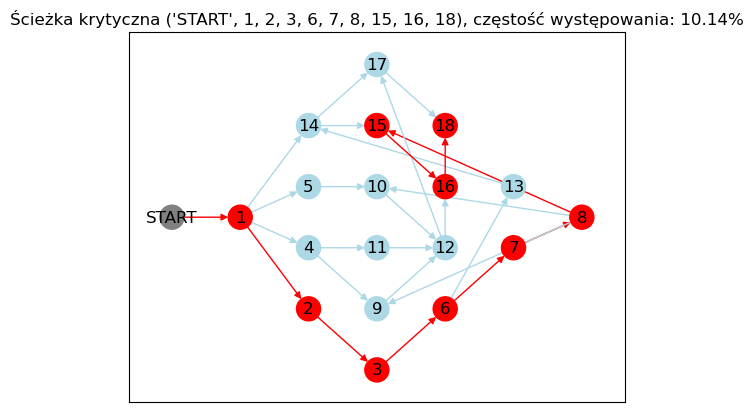

In [4]:
display(Markdown('> **Częstość wystepowania ścieżek krytycznych**'))
for c in Counter([tuple(r['path']) for r in mc_results]).most_common():
    _ = draw_critical_path(graph=graph,cpm_path=c[0], color='red')
    plt.title(f'Ścieżka krytyczna {c[0]}, częstość występowania: {c[1]/MC_STEPS*100}%')
    plt.show()

> **Zadania na ścieżce krytycznej**

,TaskId,% na ścieżce krytycznej
0,1,100.00
1,2,100.00
2,3,100.00
3,6,100.00
4,7,100.00
5,8,100.00
8,16,100.00
9,18,100.00
7,12,89.86
6,10,67.62


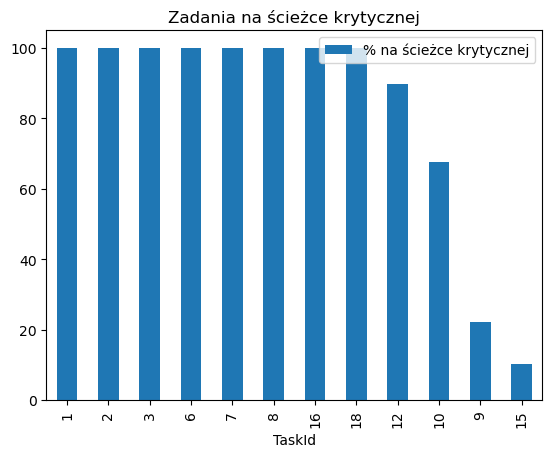

In [5]:
critical_tasks = {}
for c in Counter([tuple(r['path']) for r in mc_results]).most_common():
    for t in c[0]:
        if t != 'START':
            if t in critical_tasks:
                critical_tasks[t] = critical_tasks[t] + c[1]
            else:
                critical_tasks[t] = c[1]
df_critical_tasks = pd.DataFrame.from_dict(critical_tasks, orient='index').reset_index()
df_critical_tasks[0] = df_critical_tasks[0]/100 
df_critical_tasks = df_critical_tasks.rename(columns={'index':'TaskId', 0:'% na ścieżce krytycznej'})
df_critical_tasks = df_critical_tasks.sort_values('% na ścieżce krytycznej', ascending=False)

display(Markdown('> **Zadania na ścieżce krytycznej**'))
display(df_critical_tasks)
df_critical_tasks.plot.bar(x='TaskId',y='% na ścieżce krytycznej')
plt.title('Zadania na ścieżce krytycznej')
plt.show()

In [6]:
pert_proj = {
    'Szacowany czas (TE):':project_features['TE_proj'],
    'Odchylenie standardowe:':project_features['TE_StDev_proj']
}
pd.DataFrame.from_dict(pert_proj, orient='index',columns=['Wartość'])

,Wartość
Szacowany czas (TE):,190.18
Odchylenie standardowe:,9.71


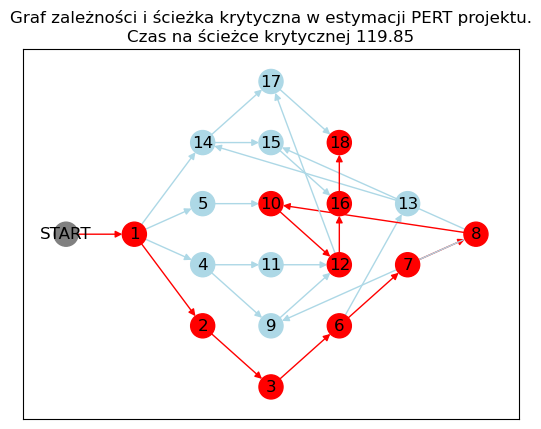

In [7]:
_ = draw_critical_path(graph=graph,cpm_path=cpm['path'], color='red')
plt.title(f"Graf zależności i ścieżka krytyczna w estymacji PERT projektu.\nCzas na ścieżce krytycznej {cpm['duration']}")
plt.show()


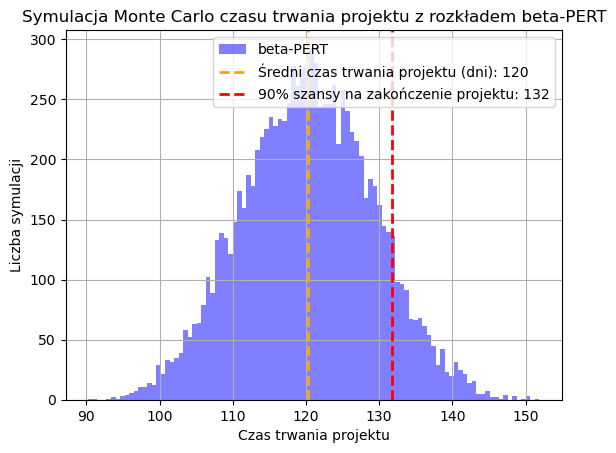

In [12]:
plt.hist(duration, bins=100, alpha=0.5, label='beta-PERT', color='blue')
plt.axvline(duration_mean, color='orange', linestyle='dashed', linewidth=2, label=f'Średni czas trwania projektu (dni): {duration_mean:.0f}')
plt.axvline(duration_percentile_90_beta, color='red', linestyle='dashed', linewidth=2, label=f'90% szansy na zakończenie projektu: {duration_percentile_90_beta:.0f}')
plt.title("Symulacja Monte Carlo czasu trwania projektu z rozkładem beta-PERT")
plt.xlabel("Czas trwania projektu")
plt.ylabel("Liczba symulacji")
plt.legend()
plt.grid(True)
plt.show()
